<a href="https://colab.research.google.com/github/Medissaoui07/Reinforcement-Learning-with-TorchRL/blob/main/RL_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 10.1 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from  torch import  nn
from tensordict.nn import TensorDictModule
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs import (
    TransformedEnv ,
    DoubleToFloat ,
    ObservationNorm ,
    StepCounter ,
    Compose

)

In [ ]:

import multiprocessing
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu"))

print(device)

cuda:0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
base_env=GymEnv("InvertedDoublePendulum-v4" , device=device)


In [ ]:
env = TransformedEnv(base_env ,Compose(
    ObservationNorm(in_keys=["observation"]),
    DoubleToFloat(),
    StepCounter(),
) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [ ]:

from torchrl.envs.utils import check_env_specs
check_env_specs(env)


2025-01-12 11:20:59,582 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
print(env.action_spec)

BoundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
    device=cuda:0,
    dtype=torch.float32,
    domain=continuous)


In [ ]:
num_cells=256
from tensordict.nn.distributions import NormalParamExtractor

ActorNetwork = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2*env.action_spec.shape[-1], device=device),
    NormalParamExtractor()
)

In [ ]:
policy_module=TensorDictModule(ActorNetwork ,
                               in_keys=["observation"],
                               out_keys=["loc" , "scale"])

In [ ]:
from torchrl.modules import TanhNormal , ProbabilisticActor
policy_module=ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    distribution_class=TanhNormal,
    in_keys=["loc" , "scale"] ,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
)

In [ ]:
from torchrl.modules import ValueOperator

ValueNetwork = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)
value_module=ValueOperator(
     module=ValueNetwork,
    in_keys=["observation"],

 )

In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

In [ ]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
frames_per_batch=1000
total_frames=10_000
max_size=64
data_collector=SyncDataCollector(
    env,
    policy=policy_module,
    device=device ,
    frames_per_batch=frames_per_batch ,
    total_frames=total_frames,
)
replay_buffer=ReplayBuffer(
    storage=LazyTensorStorage(max_size),
    sampler=SamplerWithoutReplacement(),
)

In [ ]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
gamma=0.99
clip_param=0.2
lmbda = 0.95
entropy_eps = 1e-4

advantage_module = GAE(
    value_network=value_module,
    gamma=gamma,
    lmbda=lmbda,
    average_gae=True,
)
loss=ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    advantage_module=advantage_module,
    discount=gamma,
    clip_eps=clip_param,
    entropy_eps=entropy_eps,
 )

In [ ]:
lr=0.1
optimizer=torch.optim.Adam(loss.parameters() , lr=lr  )


In [ ]:

from tqdm import tqdm
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""
num_epochs=10



# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(data_collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // max_size):
            subdata = replay_buffer.sample(max_size)
            loss_vals = loss(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded

            optimizer.step()
            optimizer.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optimizer.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.


eval cumulative reward:  82.0968 (init:  82.0968), eval step-count: 8, average reward= 9.2042 (init= 9.0823), step count (max): 15, lr policy:  0.1000: 100%|██████████| 10000/10000 [00:49<00:00, 233.41it/s]

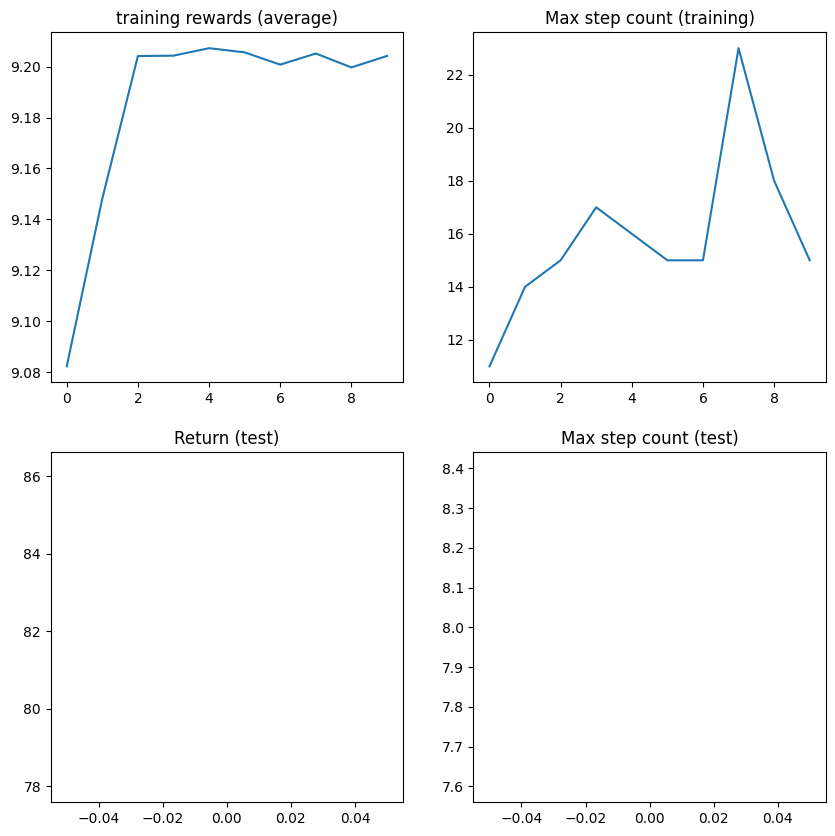

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()